In [1]:
from deepchem.molnet import load_delaney

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/mori/miniforge3/envs/flowapp/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/mori/miniforge3/envs/flowapp/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Sk

In [2]:
from deepchem.feat import MolGraphConvFeaturizer

featurizer = MolGraphConvFeaturizer(use_edges=True)
tasks, datasets, transformers = load_delaney(featurizer=featurizer, splitter="scaffold")
train_dataset, valid_dataset, test_dataset = datasets

print(tasks)
n_tasks = len(tasks)

['measured log solubility in mols per litre']


In [3]:
from deepchem.models import GATModel

model = GATModel(
    n_tasks=n_tasks,
    mode="regression",
    batch_size=32,
    learning_rate=0.001,
    n_attention_heads=8,
    n_graph_feat=128,
    n_gnn_layers=2,
    dropout=0.1,
)

model.fit(train_dataset, nb_epoch=20)

0.15460381507873536

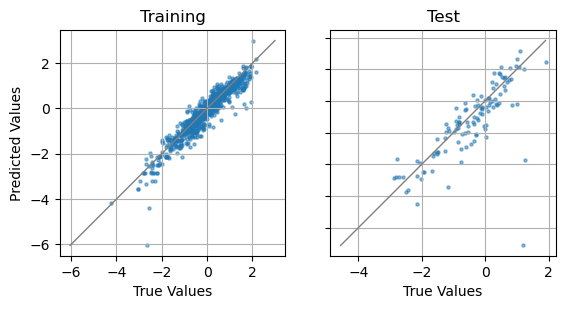

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def plot_parity(y_true, y_pred, ax, title="Parity Plot"):
    ax.scatter(y_true, y_pred, alpha=0.5, s=5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], color="gray", linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.set_aspect("equal")
    ax.label_outer()
    ax.grid(True)


y_pred_train = model.predict(train_dataset)
y_true_train = train_dataset.y

y_pred_test = model.predict(test_dataset)
y_true_test = test_dataset.y

y_pred_train = y_pred_train.flatten()
y_true_train = y_true_train.flatten()

y_pred_test = y_pred_test.flatten()
y_true_test = y_true_test.flatten()

fig, ax = plt.subplots(1, 2)
plot_parity(y_true_train, y_pred_train, ax[0], title="Training")
plot_parity(y_true_test, y_pred_test, ax[1], title="Test")

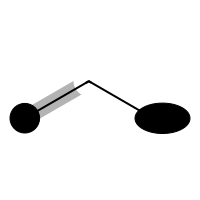

In [5]:
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D

mol = Chem.MolFromSmiles("CCO")
drawer = rdMolDraw2D.MolDraw2DSVG(200, 200)
rdMolDraw2D.PrepareAndDrawMolecule(
    drawer,
    mol,
    highlightAtoms=[0, 1, 2],
    highlightAtomColors={0: (0, 0, 0, 0.3), 1: (1, 1, 1, 0.3), 2: (0, 0, 0, 0.3)},
    highlightBonds=[0, 1],
    highlightBondColors={0: (0, 0, 0, 0.3), 1: (1, 1, 1, 0.3)},
)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace("svg:", "")
display(SVG(svg))

In [6]:
import copy

import deepchem as dc


def calc_contrib_perturb(smiles, model):
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    mol = Chem.MolFromSmiles(smiles)
    graph = featurizer.featurize([mol])
    graph_data = graph[0]

    dataset = dc.data.NumpyDataset(X=[graph_data], y=None, w=None, ids=[smiles])
    base_pred = model.predict(dataset)[0][0]

    n_atoms = graph_data.node_features.shape[0]
    n_edges = graph_data.edge_index.shape[1]

    node_contributions = {}
    for node_idx in range(n_atoms):
        perturbed_graph = copy.deepcopy(graph_data)

        # Perturb the node feature
        perturbed_graph.node_features[node_idx, :] = 0.0

        perturbed_dataset = dc.data.NumpyDataset(
            X=[perturbed_graph], y=None, w=None, ids=[smiles]
        )
        perturbed_pred = model.predict(perturbed_dataset)[0][0]

        delta_pred = base_pred - perturbed_pred
        node_contributions[node_idx] = delta_pred

    edge_contributions = {}
    for edge_idx in range(n_edges):
        perturbed_graph = copy.deepcopy(graph_data)
        mask = np.ones(n_edges, dtype=bool)
        mask[edge_idx] = False
        perturbed_graph.edge_index = perturbed_graph.edge_index[:, mask]
        perturbed_graph.edge_features = perturbed_graph.edge_features[mask]
        perturbed_dataset = dc.data.NumpyDataset(
            X=[perturbed_graph], y=None, w=None, ids=[smiles]
        )
        perturbed_pred = model.predict(perturbed_dataset)[0][0]
        delta_pred = base_pred - perturbed_pred
        bond_idx = list(set(graph_data.edge_index[:, edge_idx]))
        bond = mol.GetBondBetweenAtoms(int(bond_idx[0]), int(bond_idx[1]))
        if bond.GetIdx() in edge_contributions:
            edge_contributions[bond.GetIdx()] += delta_pred
        else:
            edge_contributions[bond.GetIdx()] = delta_pred

    return {
        "nodes": node_contributions,
        "edges": edge_contributions,
    }

In [7]:
contribs = calc_contrib_perturb("CCO", model)

In [8]:
contribs

{'nodes': {0: -0.086606145, 1: -0.15635324, 2: 1.1953355},
 'edges': {0: -0.07485783, 1: -0.23894477}}

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as colors

cmap = cm.get_cmap("bwr_r")
atom_colors = {}
vmin, vmax = -2, 2
alpha_value = 0.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)

for i, val in contribs["nodes"].items():
    rgba = list(cmap(norm(val)))
    rgba[3] = alpha_value
    atom_colors[i] = tuple(rgba)

/tmp/ipykernel_21176/752769321.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr_r")


In [10]:
atom_colors

{0: (1.0, 0.9568627450980391, 0.9568627450980391, 0.5),
 1: (1.0, 0.9176470588235294, 0.9176470588235294, 0.5),
 2: (0.4, 0.4, 1.0, 0.5)}

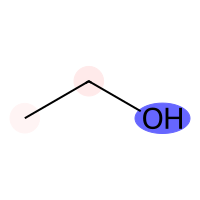

In [11]:
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D

mol = Chem.MolFromSmiles("CCO")
drawer = rdMolDraw2D.MolDraw2DSVG(200, 200)
rdMolDraw2D.PrepareAndDrawMolecule(
    drawer,
    mol,
    highlightAtoms=list(atom_colors.keys()),
    highlightAtomColors=atom_colors,
)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace("svg:", "")
display(SVG(svg))

In [12]:
bond_colors = {}
alpha_value = 0.5
cmap = cm.get_cmap("bwr_r")
for i, val in contribs["edges"].items():
    rgba = list(cmap(norm(val)))
    rgba[3] = alpha_value
    bond_colors[i] = tuple(rgba)

/tmp/ipykernel_21176/1928899192.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr_r")


In [13]:
bond_colors

{0: (1.0, 0.9647058823529412, 0.9647058823529412, 0.5),
 1: (1.0, 0.8784313725490196, 0.8784313725490196, 0.5)}

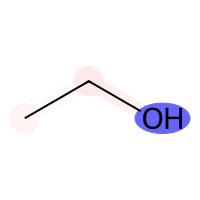

In [14]:
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D

mol = Chem.MolFromSmiles("CCO")
drawer = rdMolDraw2D.MolDraw2DSVG(200, 200)
rdMolDraw2D.PrepareAndDrawMolecule(
    drawer,
    mol,
    highlightAtoms=list(atom_colors.keys()),
    highlightAtomColors=atom_colors,
    highlightBonds=list(bond_colors.keys()),
    highlightBondColors=bond_colors,
)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace("svg:", "")
display(SVG(svg))

In [15]:
def visualize_contributions(
    smi, model, cmap="bwr_r", alpha=0.9, vmin=-0.5, vmax=0.5, size=(250, 250)
):
    contribs = calc_contrib_perturb(smi, model)
    cmap = cm.get_cmap(cmap)
    atom_colors = {}

    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for i, val in contribs["nodes"].items():
        rgba = list(cmap(norm(val)))
        rgba[3] = alpha
        atom_colors[i] = tuple(rgba)

    bond_colors = {}
    for i, val in contribs["edges"].items():
        rgba = list(cmap(norm(val)))
        rgba[3] = alpha
        bond_colors[i] = tuple(rgba)

    mol = Chem.MolFromSmiles(smi)
    drawer = rdMolDraw2D.MolDraw2DSVG(*size)
    rdMolDraw2D.PrepareAndDrawMolecule(
        drawer,
        mol,
        highlightAtoms=list(atom_colors.keys()),
        highlightAtomColors=atom_colors,
        highlightBonds=list(bond_colors.keys()),
        highlightBondColors=bond_colors,
    )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace("svg:", "")
    display(SVG(svg))

/tmp/ipykernel_21176/4125747207.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


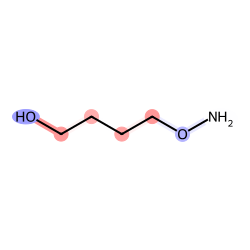

In [16]:
visualize_contributions("OCCCCON", model)